In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
# Get constants
with open("params_train.json", 'r') as file:
    params = json.load(file)

agent_name      = params['training']['AGENT_NAME']
model_name      = params['training']['MODEL_NAME']
training_rounds = params['training']['TRAINING_ROUNDS']
scenario        = params['training']['SCENARIO']
old_model       = params['training']['START_TRAINING_WITH']

alpha  = params['Q-update']['ALPHA']
gamma  = params['Q-update']['GAMMA']
mode   = params['Q-update']['MODE']
n_step = params['Q-update']['N']


# Print training trivia
train_str = f"Trained 'agent_{agent_name}_{model_name}' for {training_rounds} rounds "
if old_model == "RESET":
    train_str += f"from scratch."
else:
    train_str += f"starting with '{old_model}'."
print(train_str)
print(f"Performed Q-update in {n_step}-step {mode} mode.  (alpha = {alpha}, gamma = {gamma})")

Trained 'agent_h3_coin-miner8' for 5000 rounds from scratch.
Performed Q-update in 5-step SARSA mode.  (alpha = 0.1, gamma = 1)


In [3]:
# All possible features
all_direction_features = np.array(
    [
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 2],
        [0, 0, 1, 2],
        [0, 1, 1, 2],
        [1, 1, 1, 2],
        [0, 0, 2, 2],
        [0, 1, 2, 2],
        [1, 1, 2, 2],
        [0, 2, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2],   
    ]
)
all_own_spot_features  = np.array([0, 1, 2])
all_mode_features      = np.array([0, 1, 2])  

### Evaluating the trained model

In [4]:
trained_model = np.load(f"model_{agent_name}_{model_name}.npy")
Sa_counter    = np.load(f"sa_counter_{agent_name}_{model_name}.npy")
policy        = np.argmax(trained_model, axis = -1)

In [5]:
def look_up_q_tensor(f5, f6):
    print(f"Q-Tensor for case (f5 = {f5}, f6 = {f6}):")
    print(f"state  direction features   policy  trained model  {'':20}number of encounters")
    for i in range(len(all_direction_features)):
        line = f"{i:2}{'':2}{all_direction_features[i]} {[f5, f6]}{'':2}{policy[i, f5, f6]}{'':2}["
        for Q_value in trained_model[i, f5, f6]:
            line += f"{Q_value:-7.1f}"
        line += f"]  {np.sum(Sa_counter[i, f5, f6]):5} ["
        for count in Sa_counter[i, f5, f6]:
            line += f" {count:5}"
        line += f"]"
        print(line)

In [6]:
look_up_q_tensor(1, 0)

Q-Tensor for case (f5 = 1, f6 = 0):
state  direction features   policy  trained model                      number of encounters
 0  [0 0 0 0] [1, 0]  4  [   38.9   38.1   26.5   37.1   78.2   33.7]   5005 [    71    61    60    62  4686    65]
 1  [0 0 0 1] [1, 0]  4  [   39.8   36.3   31.3   42.5   78.6   47.4]   6374 [    74    85    78  1831  4238    68]
 2  [0 0 1 1] [1, 0]  3  [    5.5    4.3   18.7   76.6    7.9   19.8]    809 [    10     7    15   750    12    15]
 3  [0 1 1 1] [1, 0]  4  [    1.2   18.4   18.2   24.1   78.5   11.5]    968 [     7     6     7     8   934     6]
 4  [1 1 1 1] [1, 0]  0  [    0.0    0.0    0.0    0.0    0.0    0.0]      0 [     0     0     0     0     0     0]
 5  [0 0 0 2] [1, 0]  3  [   72.7   71.4   73.6   77.3   74.5   72.2]  161760 [  1186  1144  1182 93632 63041  1575]
 6  [0 0 1 2] [1, 0]  2  [   74.2   71.7   77.2   75.0   73.5   76.4]  381345 [  4480  5530 140238 72482 149101  9514]
 7  [0 1 1 2] [1, 0]  3  [   62.4   67.8   67.3   79.6  

## Looking at the training process

### Training performance over rounds

In [7]:
def moving_average (x, w):
    """
    from https://newbedev.com/how-to-calculate-rolling-moving-average-using-numpy-scipy
    """
    return np.convolve(x, np.ones(w), 'valid') / w

In [8]:
with open("results_train.json", 'r') as file:
    training_results = json.load(file)

In [9]:
number_of_rounds = training_results['by_agent'][f"agent_{agent_name}"]['rounds']
round_list       = list(training_results['by_round'])
rounds           = np.arange(number_of_rounds) + 1
collected_coins  = np.zeros(number_of_rounds, dtype = int)
round_lengths    = np.zeros(number_of_rounds, dtype = int)
kills            = np.zeros(number_of_rounds, dtype = int)
suicides         = np.zeros(number_of_rounds, dtype = int)
died             = np.zeros(number_of_rounds, dtype = int)
invalid_moves    = np.zeros(number_of_rounds, dtype = int)

for round_name in round_list:
    round_dict             = training_results['by_round'][round_name]
    round                  = round_dict['round'] - 1   # round index
    collected_coins[round] = round_dict['coins'][0]
    round_lengths[round]   = round_dict['steps']
    kills[round]           = round_dict['kills'][0]
    suicides[round]        = round_dict['suicides'][0]
    died[round]            = round_dict['got killed'][0]
    invalid_moves[round]   = round_dict['invalid'][0]


In [10]:
survived        = 1 - died
was_killed      = died - suicides
steps_survived  = np.where(died, round_lengths, 400)

In [11]:
avg_length   = 50   # number of rounds to average over

kill_rate           = moving_average(kills, avg_length)
suicide_rate        = moving_average(suicides, avg_length)
was_killed_rate     = moving_average(was_killed, avg_length)
died_rate           = moving_average(died, avg_length)
steps_survived_rate = moving_average(steps_survived, avg_length)


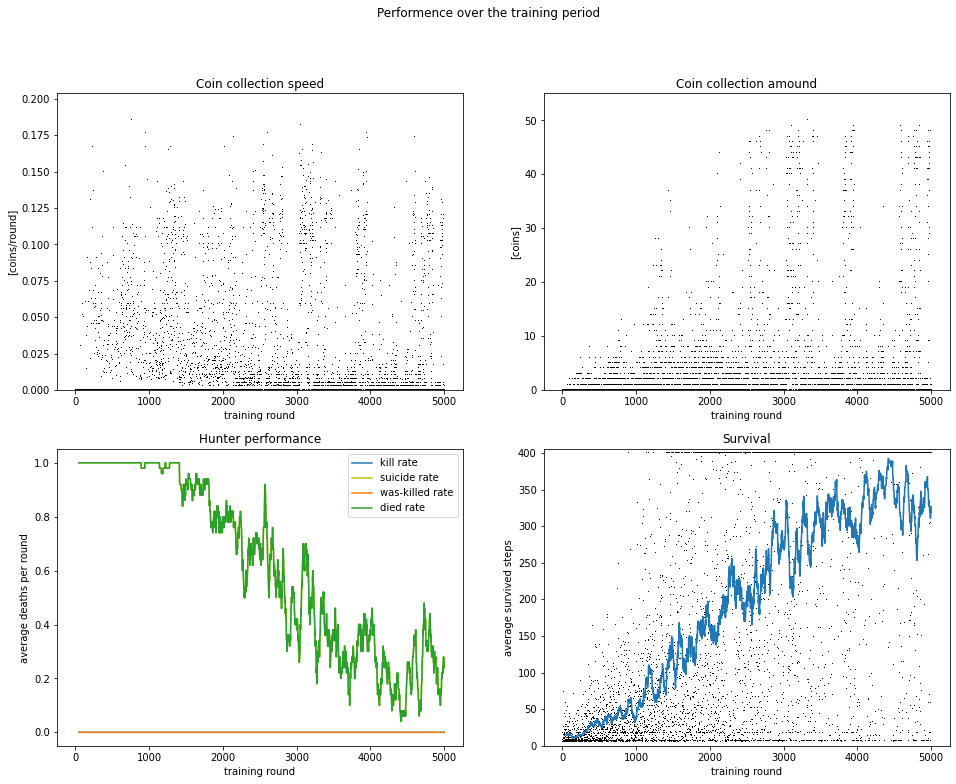

In [12]:
plt.figure(figsize = (16,12))
plt.suptitle("Performence over the training period")

plt.subplot(2, 2, 1)
speed = collected_coins / round_lengths
plt.plot(rounds, speed, ',k')
plt.ylim((0, 1.1*max(speed)))
plt.title("Coin collection speed")
plt.ylabel("[coins/round]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.subplot(2, 2, 2)
plt.plot(rounds, collected_coins, ',k')
plt.ylim((0, 1.1*max(collected_coins)))
plt.title("Coin collection amound")
plt.ylabel("[coins]")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.subplot(2, 2, 3)
plt.plot(rounds[avg_length-1:], kill_rate, label = "kill rate")
plt.plot(rounds[avg_length-1:], suicide_rate, 'y', label = "suicide rate")
plt.plot(rounds[avg_length-1:], was_killed_rate, label = "was-killed rate")
plt.plot(rounds[avg_length-1:], died_rate, label = "died rate")
plt.xlim(-0.05*number_of_rounds, 1.05*number_of_rounds)
plt.title("Hunter performance")
plt.ylabel("average deaths per round")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(rounds, steps_survived, ',k')
plt.plot(rounds[avg_length-1:], steps_survived_rate)
plt.ylim(0, 405)
plt.xlim(-0.05*number_of_rounds, 1.05*number_of_rounds)
plt.title("Survival")
plt.ylabel("average survived steps")   # speed of 0.4 would be considerad great performance
plt.xlabel("training round")

plt.show()



In [13]:
def analyze_action(mode = "all"):
    title_str = "Evolution of actions"
    
    if mode == "all":
        Q_action = np.mean(allQs, axis = (1,2,3))
    else:
        Q_action = np.mean(allQs[:, :, :, mode], axis = (1,2))
        title_str += f" in mode {mode}"
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(number_of_rounds) + 1, Q_action, label = labels)
    plt.title(title_str)
    plt.ylabel("Mean Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

In [14]:
def analyze_state (state):
    state_index, f5, f6 = state
    Q_state = allQs[:, state_index, f5, f6]
    labels  = ["action 0", "action 1", "action 2", "action 3", "WAIT", "BOMB"]

    plt.plot(np.arange(training_rounds) + 1, Q_state, label = labels)
    plt.title(f"Evolution of state {state}")
    plt.ylabel("Q-value")
    plt.xlabel("training round")
    plt.legend()
    plt.show()

### Evolution of the Q-model

In [15]:
allQs = np.load("Qtrain.npy")

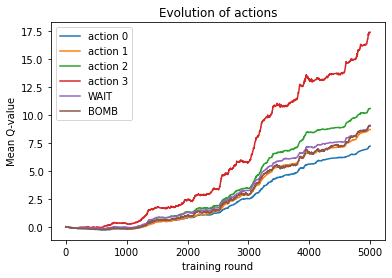

In [16]:
analyze_action()

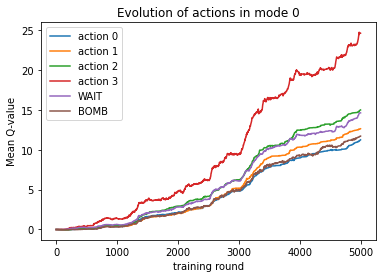

In [17]:
analyze_action(0)

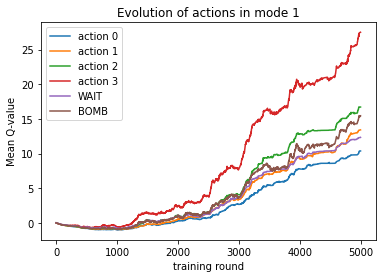

In [18]:
analyze_action(1)

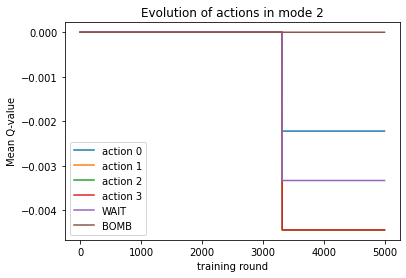

In [19]:
analyze_action(2)

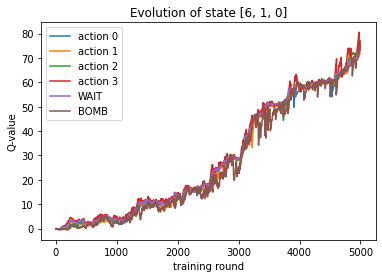

In [20]:
analyze_state([6, 1, 0])